<a href="https://colab.research.google.com/github/REZAKAZAZI00/nbert/blob/main/nbert_12_05ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U "transformers>=4.30.0" datasets torch accelerate evaluate scikit-learn nltk


In [2]:
import os
import re
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from nltk.stem import WordNetLemmatizer
from transformers import (
    AutoTokenizer, AutoModel, TrainingArguments, Trainer, set_seed
)
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score, f1_score
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

os.environ["WANDB_MODE"] = "offline"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
MODEL_NAME = "bert-base-uncased"
DATASET_NAME = "nbertagnolli/counsel-chat"
MAX_LEN = 256
BATCH_SIZE = 16
LR = 3e-5
EPOCHS = 5
SEED = 42

set_seed(SEED)

NRC_EMOTIONS = ["anger","anticipation","disgust","fear","joy","sadness","surprise","trust","positive","negative"]


In [4]:
NRC_PATH = "/content/drive/MyDrive/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

def load_nrc_lexicon(path):
    lex = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                word, emotion, assoc = parts
                if assoc == '1':
                    lex.setdefault(word, []).append(emotion)
    return lex

nrc_lex = load_nrc_lexicon(NRC_PATH)
lemmatizer = WordNetLemmatizer()

In [5]:
def sentence_to_nrc_vector(text, lex):
    tokens = word_tokenize(str(text).lower())
    vec = np.zeros(len(NRC_EMOTIONS))
    for t in tokens:
        clean = re.sub(r'\W+', '', t)
        if not clean:
            continue
        lem = lemmatizer.lemmatize(clean)
        emos = lex.get(lem) or lex.get(clean)
        if emos:
            for e in emos:
                if e in NRC_EMOTIONS:
                    vec[NRC_EMOTIONS.index(e)] += 1
    if vec.sum() > 0:
        vec = vec / vec.sum()
    return vec


In [6]:
class CounselChatEmotionDataset(Dataset):
    def __init__(self, ds, tokenizer, max_len=256, nrc_lex=None):
        self.ds = ds
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.nrc_lex = nrc_lex

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        text = row.get("text") or row.get("content") or str(row)

        nrc_vec = sentence_to_nrc_vector(text, self.nrc_lex)

        tok = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_len
        )

        label = row.get("label", np.argmax(nrc_vec))

        return {
            "input_ids": tok["input_ids"],
            "attention_mask": tok["attention_mask"],
            "nrc_vec": nrc_vec.astype(np.float32),
            "label": int(label),
        }


In [7]:
class NbertLikeModel(nn.Module):
    def __init__(self, model_name, nrc_dim, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden = self.bert.config.hidden_size

        self.nrc_proj = nn.Linear(nrc_dim, hidden)
        self.classifier = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, num_labels)
        )

    def forward(self, input_ids, attention_mask, nrc_vec, labels=None):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_vec = out.last_hidden_state[:,0,:]

        nrc_vec = nrc_vec.to(cls_vec.device)
        nrc_out = self.nrc_proj(nrc_vec)

        cat = torch.cat([cls_vec, nrc_out], dim=-1)
        logits = self.classifier(cat)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return {"loss": loss, "logits": logits}


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

raw = load_dataset(DATASET_NAME)
if "train" in raw and len(raw) == 1:
    ds = raw["train"].train_test_split(test_size=0.2, seed=SEED)
else:
    ds = raw

train_ds = CounselChatEmotionDataset(ds["train"], tokenizer, MAX_LEN, nrc_lex)
val_ds = CounselChatEmotionDataset(ds["test"], tokenizer, MAX_LEN, nrc_lex)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Repo card metadata block was not found. Setting CardData to empty.


In [9]:
def collate_fn(batch):
    ids = [b["input_ids"] for b in batch]
    masks = [b["attention_mask"] for b in batch]
    nrc = torch.tensor([b["nrc_vec"] for b in batch])
    labels = torch.tensor([b["label"] for b in batch])

    padded = tokenizer.pad(
        {"input_ids": ids, "attention_mask": masks},
        return_tensors="pt"
    )
    padded["nrc_vec"] = nrc
    padded["labels"] = labels
    return padded


In [11]:
from transformers import TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted")
    }

train_size = len(train_ds)
steps_per_epoch = max(1, train_size // BATCH_SIZE)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    logging_steps=50,
    do_eval=True,
    eval_steps=steps_per_epoch,
    save_steps=steps_per_epoch,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

model = NbertLikeModel(
    model_name=MODEL_NAME,
    nrc_dim=len(NRC_EMOTIONS),
    num_labels=len(NRC_EMOTIONS)
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)


In [12]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


/tmp/ipython-input-4155874007.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  nrc = torch.tensor([b["nrc_vec"] for b in batch])
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
50,1.427800
100,1.145800
150,1.127200
200,0.924000
250,0.975200
300,0.815100
350,0.797700
400,0.741300
450,0.696200
500,0.623100


Step,Training Loss
50,1.427800
100,1.145800
150,1.127200
200,0.924000
250,0.975200
300,0.815100
350,0.797700
400,0.741300
450,0.696200
500,0.623100


TrainOutput(global_step=695, training_loss=0.8130336102821845, metrics={'train_runtime': 410.3031, 'train_samples_per_second': 27.053, 'train_steps_per_second': 1.694, 'total_flos': 0.0, 'train_loss': 0.8130336102821845, 'epoch': 5.0})

In [13]:
preds = trainer.predict(val_ds)
y_pred = preds.predictions.argmax(-1)
y_true = preds.label_ids

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.34      0.33      0.34        30
           3       0.00      0.00      0.00        14
           5       0.43      0.35      0.38        26
           7       0.62      0.18      0.28        45
           8       0.76      0.86      0.81       340
           9       0.52      0.58      0.55        98

    accuracy                           0.68       555
   macro avg       0.38      0.33      0.34       555
weighted avg       0.65      0.68      0.65       555



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [14]:
trainer.save_model("./nbert_model")
print("Model saved!")


Model saved!


In [22]:
import re
import nltk
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()

def clean_simple(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text


def raw_emotion_vector_for_text(text: str, nrc_lexicon, emotions=NRC_EMOTIONS):
    text = clean_simple(text)
    tokens = text.split()
    counts = Counter()
    for tok in tokens:
        lem = lemmatizer.lemmatize(tok)
        emos = nrc_lexicon.get(lem) or nrc_lexicon.get(tok)
        if emos:
            for emo in emos:
                if emo in emotions:
                    counts[emo] += 1
    vec = np.zeros(len(emotions), dtype=np.float32)
    for i, emo in enumerate(emotions):
        vec[i] = counts[emo]
    return vec

print("Calculating emotion vectors from the training dataset...")
all_vectors = []
for sample in train_ds.ds:
    text = sample.get("text") or sample.get("content") or str(sample)
    vector = raw_emotion_vector_for_text(text, nrc_lex)
    all_vectors.append(vector)

df_vectors = pd.DataFrame(all_vectors, columns=NRC_EMOTIONS)
df_analysis = df_vectors[df_vectors.sum(axis=1) > 0].copy()
corr_matrix = df_analysis.corr()

print("Correlation matrix calculated.")

Calculating emotion vectors from the training dataset...
Correlation matrix calculated.


--- 7.3: Plotting Figure 5 (Correlation Matrix) ---


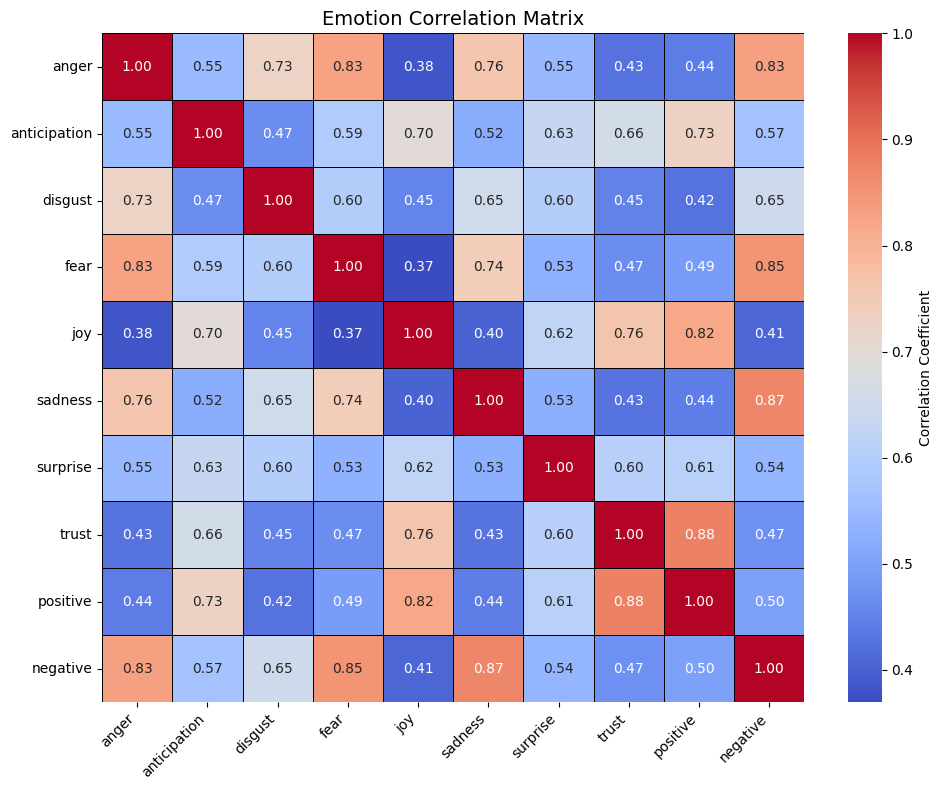

In [24]:
print("--- 7.3: Plotting Figure 5 (Correlation Matrix) ---")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'}, linewidths=.5, linecolor='black', xticklabels=NRC_EMOTIONS, yticklabels=NRC_EMOTIONS)
plt.title('Emotion Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()